In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [4]:
def create_base_network(input_shape):
    model = Sequential()  
    model.add(Conv2D(filters=16,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(Conv2D(filters=36,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Dropout(0.25))  
    model.add(Flatten()) 
    model.add(Dense(128, activation='relu'))  
    return model

In [5]:
input_shape = (174, 358, 1)
nb_epoch = 10
num_classes = 1

In [6]:
base_network = create_base_network(input_shape)

In [7]:
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [8]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [9]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)


In [10]:
im = cv2.imread('01/0101.tif',0)

In [11]:
img = cv2.resize(im,(358,174),interpolation=cv2.INTER_CUBIC)

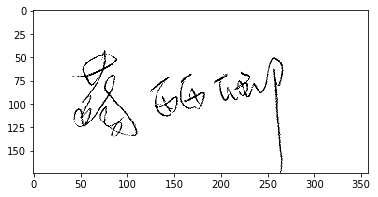

In [12]:
plt.imshow(img,cmap='gray')

In [13]:

# p for person
for p1 in range(1,31):
    
    tr_pairs = []
    tr_y = []
    
    te_pairs = []
    te_y = []
    
    # l for left
    for l in range(1, 31):
        for r in range(1, 31):
            left = '{:02d}/{:02d}{:02d}.tif'.format(p1, 1, l)
            same = '{:02d}/{:02d}{:02d}.tif'.format(p1, 1, r)
            diff = '{:02d}/{:02d}{:02d}.tif'.format(r, 3, p1)
#             print('{},{}'.format(left, same))
#             print('{},{}'.format(left, diff))
            
            im_left = cv2.imread(left, 0)
            im_left = cv2.resize(im_left,(358,174),interpolation=cv2.INTER_CUBIC)
            im_left = im_left/255
            
            im_same = cv2.imread(same, 0)
            im_same = cv2.resize(im_same,(358,174),interpolation=cv2.INTER_CUBIC)
            im_same = im_same/255
            
            im_diff = cv2.imread(diff, 0)
            im_diff = cv2.resize(im_diff,(358,174),interpolation=cv2.INTER_CUBIC)
            im_diff = im_diff/255
            
            tr_pairs += [im_left, im_same]
            tr_y += [1]
            
            tr_pairs += [im_left, im_diff]
            tr_y += [0]
            
    
    tr_pairs = np.array(tr_pairs)
    tr_pairs = tr_pairs.reshape(1800, 2, 174, 358, 1)
    tr_y = np.array(tr_y)
    
    print(p1)
    print(tr_pairs.shape)
    print(tr_y.shape)
    
    model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], 
              tr_y,
              validation_split=0.2,
              batch_size=128,
              epochs=nb_epoch)
    
    file = 'signature_model_{:02d}.h5'.format(p1)
    
    model.save(file)
    
    
    

1
(1800, 2, 174, 358, 1)
(1800,)
Train on 1440 samples, validate on 360 samples
Epoch 1/10
1440/1440 [==============================] - 152s - loss: 0.2178 - val_loss: 0.0145
Epoch 2/10
1440/1440 [==============================] - 145s - loss: 0.0149 - val_loss: 0.0112
Epoch 3/10
1440/1440 [==============================] - 149s - loss: 0.0364 - val_loss: 0.0025
Epoch 4/10
1440/1440 [==============================] - 148s - loss: 0.0077 - val_loss: 0.0198
Epoch 5/10
1440/1440 [==============================] - 143s - loss: 0.0153 - val_loss: 0.0033
Epoch 6/10
1440/1440 [==============================] - 148s - loss: 0.0049 - val_loss: 0.0087
Epoch 7/10
1440/1440 [==============================] - 148s - loss: 0.0196 - val_loss: 0.0022
Epoch 8/10
1440/1440 [==============================] - 148s - loss: 0.0380 - val_loss: 0.0057
Epoch 9/10
1440/1440 [==============================] - 145s - loss: 0.0030 - val_loss: 9.0632e-04
Epoch 10/10
1440/1440 [==============================] - 147s

1440/1440 [==============================] - 139s - loss: 0.0015 - val_loss: 4.3802e-04
9
(1800, 2, 174, 358, 1)
(1800,)
Train on 1440 samples, validate on 360 samples
Epoch 1/10
1440/1440 [==============================] - 136s - loss: 0.0256 - val_loss: 0.0015
Epoch 2/10
1440/1440 [==============================] - 138s - loss: 0.0011 - val_loss: 0.0013
Epoch 3/10
1440/1440 [==============================] - 140s - loss: 0.0014 - val_loss: 9.3554e-04
Epoch 4/10
1440/1440 [==============================] - 144s - loss: 0.0019 - val_loss: 9.7333e-04
Epoch 5/10
1440/1440 [==============================] - 142s - loss: 0.0012 - val_loss: 0.0012
Epoch 6/10
1440/1440 [==============================] - 140s - loss: 0.0017 - val_loss: 0.0031
Epoch 7/10
1440/1440 [==============================] - 149s - loss: 0.0013 - val_loss: 4.5413e-04
Epoch 8/10
1440/1440 [==============================] - 144s - loss: 0.0018 - val_loss: 5.9810e-04
Epoch 9/10
1440/1440 [==============================] - 

1440/1440 [==============================] - 140s - loss: 0.0029 - val_loss: 0.0104
Epoch 8/10
1440/1440 [==============================] - 140s - loss: 0.0072 - val_loss: 0.0010
Epoch 9/10
1440/1440 [==============================] - 141s - loss: 0.0021 - val_loss: 0.0032
Epoch 10/10
1440/1440 [==============================] - 141s - loss: 0.0035 - val_loss: 0.0011
25
(1800, 2, 174, 358, 1)
(1800,)
Train on 1440 samples, validate on 360 samples
Epoch 1/10
1440/1440 [==============================] - 139s - loss: 0.0435 - val_loss: 0.0046
Epoch 2/10
1440/1440 [==============================] - 140s - loss: 0.0039 - val_loss: 9.0281e-04
Epoch 3/10
1440/1440 [==============================] - 142s - loss: 0.0031 - val_loss: 0.0028
Epoch 4/10
1440/1440 [==============================] - 135s - loss: 0.0034 - val_loss: 0.0011
Epoch 5/10
1440/1440 [==============================] - 137s - loss: 0.0018 - val_loss: 0.0017
Epoch 6/10
1440/1440 [==============================] - 137s - loss: 0

In [ ]:
model.save('signature_model.h5')